# SH 2nd Random Forest Scaling done 
## public : 1.0527328564 / private : 1.0190300535 / log_loss: 0.7860780975347138

1st의 패치 문제 해결 후 실행.. 하지만 눈을 의심하는 점수가 나옴ㅠ

log_loss와 점수가 비슷할 것으로 예상했지만 아님. 점수와의 상관성 확인 요망.

## develop 
- work_year & work_total의 다중공선성 높기때문에 하나만 채택할 것
- begin_month 반영한 new_age, work 칼럼 생성할 것
- 파생변수 생성
- 앙상블 모델
  

## 필요한 라이브러리 호출

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
from sklearn.preprocessing import OrdinalEncoder


warnings.filterwarnings('ignore')

## 데이터 전처리 과정

In [2]:
# 경로 설정 (dataset을 저장하는 경로임.)
path = 'C:/Users/user/Desktop/code/[유비온]신용카드 사용자 연제 예측/'

train = pd.read_csv('{}train.csv'.format(path))
test = pd.read_csv('{}test.csv'.format(path))
submission = pd.read_csv('{}sample_submission.csv'.format(path))

In [3]:
#쓸모없는 칼럼 삭제
for df in (train,test):
    df.drop(['FLAG_MOBIL'], axis=1, inplace=True)   
    df.drop(columns=['index'], inplace=True)
    
del df

### 1. 나이, 고용일자를 이용하여 파생변수 형성

In [4]:
# 1st

def year_month_total(df_1, df_2, column, column_name):
    """[나이, 고용연수 파생변수를 생성하기 위한 함수입니다.]

    Args:
        df_1 ([DataFrame]): [데이터 프레임 이름을 입력해주세요]
        df_2 ([DataFrame]): [데이터 프레임 이름을 입력해주세요]
        column ([생성할 컬럼의 기준 컬럼 명]): [생성할 컬럼의 기준 컬럼 명을 입력해주세요]
        column_name ([생성할 컬럼의 이름]): [연단위, 연+월단위로 표시된 파생변수 이름입니다.]
    """
    # 변수 설정
    
    df_list = []
    df_list.append(df_1)
    df_list.append(df_2)
    names = ['train', 'test']
    
    # 입력한 컬럼이 DAYS_BIRTH인 경우 If로 처리
    
    if (column == 'DAYS_BIRTH') == True:    
        for dataset,name in zip(df_list,names):
            dataset['{}_year'.format(column_name)] = dataset[column].abs()//365
            dataset['{}_month'.format(column_name)] = (dataset[column].abs()%365)//30
            dataset['{}_total'.format(column_name)] = dataset['{}_year'.format(column_name)] + round(dataset['{}_month'.format(column_name)] * (1/12), 2)
            dataset.drop(columns=['{}_month'.format(column_name)], inplace=True)
        
            print('{0}set에 {1}_year, {1}_total 컬럼을 생성하였습니다. \n'.format(name,column_name))
    
    # 입력한 컬럼이 DAYS_EMPLOYED인 경우 else로 처리 (occyp_type 처리를 위한 작업이므로 1번째로 수행)
    
    else:
        for dataset,name in zip(df_list,names):
            print('{}set에 근무일자가 잘못기입된 '.format(name) +
                  '\033[96m' + '{} cases'.format(len(dataset[dataset['DAYS_EMPLOYED']>=0])) + 
                  '\033[0m' + '에 대한 처리를 시작합니다.')
            dataset['DAYS_EMPLOYED'] = dataset['DAYS_EMPLOYED'].replace(365243, 0)
            
            dataset['{}_year'.format(column_name)] = dataset[column].abs()//365
            dataset['{}_month'.format(column_name)] = (dataset[column].abs()%365)//30
            dataset['{}_total'.format(column_name)] = dataset['{}_year'.format(column_name)] + round(dataset['{}_month'.format(column_name)] * (1/12), 2)
            dataset.drop(columns=['{}_month'.format(column_name)], inplace=True)
        
            print('{0}set에 {1}_year, {1}_total 컬럼을 생성하였습니다. \n'.format(name, column_name))
        
    del df_list,names
    return dataset.head(1)

    

In [5]:
year_month_total(train, test,'DAYS_BIRTH','age')

trainset에 age_year, age_total 컬럼을 생성하였습니다. 

testset에 age_year, age_total 컬럼을 생성하였습니다. 



,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,age_year,age_total
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,0,1,0,NaN,2.0,-60.0,60,60.25


In [6]:
year_month_total(train, test,'DAYS_EMPLOYED','work')

trainset에 근무일자가 잘못기입된 4438 cases에 대한 처리를 시작합니다.
trainset에 work_year, work_total 컬럼을 생성하였습니다. 

testset에 근무일자가 잘못기입된 1697 cases에 대한 처리를 시작합니다.
testset에 work_year, work_total 컬럼을 생성하였습니다. 



,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,work_phone,phone,email,occyp_type,family_size,begin_month,age_year,age_total,work_year,work_total
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,...,0,1,0,NaN,2.0,-60.0,60,60.25,0,0.0


### 2. 직업 Nan 값 처리

In [7]:
# 2nd

def occyp_type_nan(df_1, df_2):
    """[직업 컬럼 내의 Nan 값을 처리합니다.]

    Args:
        df_1 ([DataFrame]): [데이터 프레임 이름을 입력해주세요]
        df_2 ([DataFrame]): [데이터 프레임 이름을 입력해주세요]
    """
    # 변수 설정
    
    df_list = []
    df_list.append(df_1)
    df_list.append(df_2)
    names = ['train', 'test']

    # 무직자 처리 함수
    
    for dataset,name in zip(df_list,names):
        dataset['occyp_type'] = dataset['occyp_type'].fillna('Nan')
        
        print('직업 컬럼의 ' +
              '\033[92m' + 'Nan value {}명 중 '.format(len(dataset.loc[dataset['occyp_type'] == 'Nan'])) +
              '\033[96m' + '{}명이 실제 고용일수가 0일입니다. '.format(len(dataset.loc[(dataset['occyp_type'] == 'Nan') & (dataset['DAYS_EMPLOYED'] == 0)])) + 
              '\033[0m'+ '따라서 jobless로 처리합니다.')
        
        dataset.loc[(dataset['occyp_type'] == 'Nan') & (dataset['DAYS_EMPLOYED'] == 0), 'occyp_type'] = 'jobless'
        
        # 무직자는 아니지만 데이터가 없는 경우
        
        print('나머지 {}명 데이터는 no_data로 처리합니다.'.format(len(dataset.loc[dataset['occyp_type'] == 'Nan'])))
        
        dataset.loc[dataset['occyp_type'] == 'Nan', 'occyp_type'] = 'no data'
        
        print('{}set의 직업 Nan value를 처리하였습니다.\n'.format(name))
        
    del df_list, names
    return dataset.head(1)

occyp_type_nan(train, test)

직업 컬럼의 Nan value 8171명 중 4438명이 실제 고용일수가 0일입니다. 따라서 jobless로 처리합니다.
나머지 3733명 데이터는 no_data로 처리합니다.
trainset의 직업 Nan value를 처리하였습니다.

직업 컬럼의 Nan value 3152명 중 1697명이 실제 고용일수가 0일입니다. 따라서 jobless로 처리합니다.
나머지 1455명 데이터는 no_data로 처리합니다.
testset의 직업 Nan value를 처리하였습니다.



,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,work_phone,phone,email,occyp_type,family_size,begin_month,age_year,age_total,work_year,work_total
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,...,0,1,0,jobless,2.0,-60.0,60,60.25,0,0.0


### 3. ID컬럼 생성

In [8]:
def ID_col(df_1, df_2):
    """[데이터 셋 전처리 함수입니다.]

    Args:
        df_1 ([Dataset]): [train 데이터셋을 입력해주세요]
        df_2 ([Dataset]): [test 데이터셋을 입력해주세요]
    """
    
    # 변수 설정
     
    df_list = []
    df_list.append(df_1)
    df_list.append(df_2)
    a = []
    change_credit = 0
    names = ['train', 'test']
    
    # ID 생성
    
    for name, dataset, in zip(names, df_list):
    #for dataset in df_list:
        dataset['ID'] = dataset['gender'].astype(str) +'.'+ dataset['car'].astype(str)+'.' + dataset['reality'].astype(str)+'.' + \
                dataset['child_num'].astype(str)+'.' + dataset['income_total'].astype(str) +'.'+ dataset['income_type'].astype(str) +'.'+ \
                dataset['edu_type'].astype(str)+'.' + dataset['family_type'].astype(str)+'.' + dataset['house_type'].astype(str) +'.'+ \
                dataset['DAYS_BIRTH'].astype(str) +'.'+ dataset['DAYS_EMPLOYED'].astype(str) +'.'+ dataset['work_phone'].astype(str) +'.'+ \
                dataset['phone'].astype(str) +'.'+ dataset['email'].astype(str) +'.' + dataset['family_size'].astype(str)+'.' + dataset['occyp_type'].astype(str)
        
        dataset = dataset.sort_values(['ID','begin_month'], ascending=[True, False])
        dataset.reset_index(inplace=True)
        dataset.drop(columns={'index'}, inplace=True)

        # OrdinalEncoder로 ID 변환
        
        print('\033[96m' + '해당 Data 내의 고유 ID 수는 {}입니다. '.format(dataset['ID'].nunique()) + 
              '\033[0m' + 'OrdinalEncoder를 이용힌 변환을 시작합니다.')
        encode = OrdinalEncoder()
        dataset[['ID']] = encode.fit_transform(dataset[['ID']])

        # Nth_card 컬럼 추가 (ID가 같은데 카드 개수가 여러 개인 사람을 대상으로 몇 번째 카드를 만들었는지 생성해준다)
        
        print('Column(Nth_card)을 생성합니다.')
        for i in tqdm(range(dataset['ID'].nunique())):
            Nth_card = len(dataset[dataset['ID']==i]) + 1
            
            while Nth_card > 0:
                Nth_card = Nth_card -1
                a.append(Nth_card)
                if Nth_card == 1:
                    break
                
        dataset['Nth_card'] = a        
        a.clear()
        print('\033[92m' + '신규로 카드를 개설한 사람의 수 : {}'.format(dataset[dataset['begin_month']==0.0]['ID'].nunique()) +
              '\033[0m')
        
        # Credit이 좋아지지 않고 악화된 경우를 체크하는 부분 (begin_month기준으로 Nth_card를 추가해줬으므로 인덱스 값을 기준으로 시행한다.)
        
        if (dataset['ID'].nunique() > 8000)==True:
            print('credit 정보를 확인하고 시간이 지나며 credit이 악화된 사례가 있는지 확인합니다.')
            for i in tqdm(range(dataset['ID'].nunique())):
                num = dataset.loc[dataset['ID'] == i]['credit'].to_list()
                for j in range(len(num)-1):
                    if (num[j] <= num[j+1]) == True:
                        pass
                    else :
                        change_credit += 1
                        break
            print('\033[96m'+'{}명 (전체 인원 중 {:.2f}%)은 credit이 개선되지 않고 악화된 사례가 존재합니다.'.format(change_credit, 
                                                                        (change_credit/dataset['ID'].nunique())*100) + 
                  '\033[0m')  
        else:
            print('\033[96m' + 'credit 정보가 없는 testset입니다.' + 
                  '\033[0m')
        
        # dataset 저장부분
        
        print('dataset(user_list_{})을 저장합니다. \n'.format(name))    
        dataset.to_csv('{}user_list_{}.csv'.format(path, name))
        
    
    del names, a
    return dataset.head(5)

In [9]:
ID_col(train, test)

해당 Data 내의 고유 ID 수는 8759입니다. OrdinalEncoder를 이용힌 변환을 시작합니다.
Column(Nth_card)을 생성합니다.


100%|██████████| 8759/8759 [00:01<00:00, 6388.87it/s]


신규로 카드를 개설한 사람의 수 : 214
credit 정보를 확인하고 시간이 지나며 credit이 악화된 사례가 있는지 확인합니다.


100%|██████████| 8759/8759 [00:01<00:00, 4849.23it/s]


1842명 (전체 인원 중 21.03%)은 credit이 개선되지 않고 악화된 사례가 존재합니다.
dataset(user_list_train)을 저장합니다. 

해당 Data 내의 고유 ID 수는 5585입니다. OrdinalEncoder를 이용힌 변환을 시작합니다.
Column(Nth_card)을 생성합니다.


100%|██████████| 5585/5585 [00:00<00:00, 6583.41it/s]


신규로 카드를 개설한 사람의 수 : 82
credit 정보가 없는 testset입니다.
dataset(user_list_test)을 저장합니다. 



,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,email,occyp_type,family_size,begin_month,age_year,age_total,work_year,work_total,ID,Nth_card
0,F,N,N,0,103500.0,Pensioner,Higher education,Married,House / apartment,-21701,...,0,jobless,2.0,-3.0,59,59.42,0,0.0,0.0,3
1,F,N,N,0,103500.0,Pensioner,Higher education,Married,House / apartment,-21701,...,0,jobless,2.0,-46.0,59,59.42,0,0.0,0.0,2
2,F,N,N,0,103500.0,Pensioner,Higher education,Married,House / apartment,-21701,...,0,jobless,2.0,-53.0,59,59.42,0,0.0,0.0,1
3,F,N,N,0,103500.0,Pensioner,Higher education,Single / not married,House / apartment,-24543,...,0,jobless,1.0,-28.0,67,67.17,0,0.0,1.0,1
4,F,N,N,0,103500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-20123,...,0,jobless,2.0,-11.0,55,55.08,0,0.0,2.0,2


In [10]:
train = pd.read_csv('{}user_list_train.csv'.format(path))
test = pd.read_csv('{}user_list_test.csv'.format(path))

### faimly_size 조정

In [11]:
def replace_value_family(df_1, df_2, num_of_outlier):
    """[Family_size의 outlier를 대치해주는 작업을 시행합니다.]

    Args:
        df_1 ([DataFrame]): [데이터 프레임 이름을 입력해주세요]
        df_2 ([DataFrame]): [데이터 프레임 이름을 입력해주세요]
        num_of_outlier ([outlier_standard]): [family_size의 outlier 기준을 입력하세요]
    """
    # 변수 설정
    
    df_list = []
    df_list.append(df_1)
    df_list.append(df_2)
    names = ['train', 'test']

    # family_size Outlier를 처리하는 작업
    
    for dataset,name in zip(df_list,names):
        
        print('family_size와 child_num의 다중공선성 문제로 child_num 컬럼을 삭제해줍니다.')
        
        dataset.drop(columns=['child_num'], inplace=True)
        
        print('\033[96m' + 'family_size {}명 이상인 사람의 수 : {}'.format(num_of_outlier, 
                                                                      len(dataset.loc[dataset['family_size'] >= num_of_outlier])) +
              '\033[0m')
        
        sub = dataset.loc[dataset['family_size']>= num_of_outlier]
        
        for i in tqdm(range(len(sub))):
        
            a = int(dataset[dataset['family_type'] == sub['family_type'].values[i]].mean()['family_size'])
            
            dataset.loc[(dataset['family_size']>= num_of_outlier), 'family_size'] = a
        
        # 잘 처리되었는지 확인하는 부분
        
        print('\033[96m' + 'family_size {}명 이상인 사람의 수 : {}'.format(num_of_outlier, 
                                                        len(dataset.loc[dataset['family_size'] >= num_of_outlier]))+
              '\033[0m')

        # family_size를 조정하고 난 후에 1인당 소득으로 total_income을 scale_down 해줌.
        
        print('1인당 소득으로 소득 수준을 조정합니다.')
        
        dataset['income_mean'] = dataset['income_total'] / dataset['family_size']
        
        print('{} 데이터 셋 처리 완료.\n'.format(name))
    
    del sub,df_list, names
    return dataset.head(1)

replace_value_family(train, test, 7)

family_size와 child_num의 다중공선성 문제로 child_num 컬럼을 삭제해줍니다.
family_size 7명 이상인 사람의 수 : 15


100%|██████████| 15/15 [00:03<00:00,  4.82it/s]


family_size 7명 이상인 사람의 수 : 0
1인당 소득으로 소득 수준을 조정합니다.
train 데이터 셋 처리 완료.

family_size와 child_num의 다중공선성 문제로 child_num 컬럼을 삭제해줍니다.
family_size 7명 이상인 사람의 수 : 10


100%|██████████| 10/10 [00:00<00:00, 20.20it/s]

family_size 7명 이상인 사람의 수 : 0
1인당 소득으로 소득 수준을 조정합니다.
test 데이터 셋 처리 완료.



,Unnamed: 0,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,occyp_type,family_size,begin_month,age_year,age_total,work_year,work_total,ID,Nth_card,income_mean
0,0,F,N,N,103500.0,Pensioner,Higher education,Married,House / apartment,-21701,...,jobless,2.0,-3.0,59,59.42,0,0.0,0.0,3,51750.0


In [12]:
names = ['train', 'test']

for name,dataset in zip(names, [train, test]):
    dataset.drop(columns=['DAYS_BIRTH','DAYS_EMPLOYED','Unnamed: 0'], inplace=True)
    dataset.to_csv('{}final_set_{}.csv'.format(path,name))

### AGE, WORK에 BEGIN_MONTH 반영한 새로운 칼럼 추가 (하다가 말았음)

In [13]:
#train.head(1)

In [14]:
#train['begin']

In [15]:
#train['age_new'] = train['age_total'] - abs(train['begin_month']//12)

In [16]:
#def month_total = 
    for dataset,name in zip(df_list,names):
        dataset['{}_year'.format(column_name)] = dataset[column].abs()//365
        dataset['{}_month'.format(column_name)] = (dataset[column].abs()%365)//30
        dataset['{}_total'.format(column_name)] = dataset['{}_year'.format(column_name)] + round(dataset['{}_month'.format(column_name)] * (1/12), 2)
        dataset.drop(columns=['{}_month'.format(column_name)], inplace=True)

IndentationError: unexpected indent (Temp/ipykernel_19888/3466632413.py, line 2)

## MinMaxScaler

In [17]:
#train minmaxscaler income_total
from sklearn.preprocessing import MinMaxScaler
income_total = pd.DataFrame(train, columns=['income_total'])
scaler = MinMaxScaler()
scaler.fit(income_total)
train['scaler_income'] = scaler.transform(income_total)
#train minmaxscaler income_mean
income_mean = pd.DataFrame(train, columns=['income_mean'])
scaler = MinMaxScaler()
scaler.fit(income_mean)
train['scaler_income_mean'] = scaler.transform(income_mean)

In [18]:
#test minmaxscaler income_total
income_total = pd.DataFrame(test, columns=['income_total'])
scaler = MinMaxScaler()
scaler.fit(income_total)
test['scaler_income'] = scaler.transform(income_total)
#test minmaxscaler income_mean
income_mean = pd.DataFrame(test, columns=['income_mean'])
scaler = MinMaxScaler()
scaler.fit(income_mean)
test['scaler_income_mean'] = scaler.transform(income_mean)

In [19]:
train.drop(columns=['income_total', 'income_mean'],inplace=True)
test.drop(columns=['income_total', 'income_mean'],inplace=True)

In [20]:
test

,gender,car,reality,income_type,edu_type,family_type,house_type,work_phone,phone,email,...,family_size,begin_month,age_year,age_total,work_year,work_total,ID,Nth_card,scaler_income,scaler_income_mean
0,F,N,N,Pensioner,Higher education,Married,House / apartment,0,1,0,...,2.0,-3.0,59,59.42,0,0.00,0.0,3,0.049419,0.047980
1,F,N,N,Pensioner,Higher education,Married,House / apartment,0,1,0,...,2.0,-46.0,59,59.42,0,0.00,0.0,2,0.049419,0.047980
2,F,N,N,Pensioner,Higher education,Married,House / apartment,0,1,0,...,2.0,-53.0,59,59.42,0,0.00,0.0,1,0.049419,0.047980
3,F,N,N,Pensioner,Higher education,Single / not married,House / apartment,0,0,0,...,1.0,-28.0,67,67.17,0,0.00,1.0,1,0.049419,0.106061
4,F,N,N,Pensioner,Secondary / secondary special,Married,House / apartment,0,0,0,...,2.0,-11.0,55,55.08,0,0.00,2.0,2,0.049419,0.047980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,M,Y,Y,Working,Secondary / secondary special,Married,House / apartment,0,0,0,...,6.0,-7.0,37,37.58,5,5.58,5583.0,1,0.026163,0.002525
9996,M,Y,Y,Working,Secondary / secondary special,Married,Co-op apartment,0,0,0,...,2.0,-2.0,31,31.17,7,7.42,5584.0,4,0.113372,0.103535
9997,M,Y,Y,Working,Secondary / secondary special,Married,Co-op apartment,0,0,0,...,2.0,-26.0,31,31.17,7,7.42,5584.0,3,0.113372,0.103535
9998,M,Y,Y,Working,Secondary / secondary special,Married,Co-op apartment,0,0,0,...,2.0,-37.0,31,31.17,7,7.42,5584.0,2,0.113372,0.103535


## MODELING

In [21]:
#타입 구분
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  14
Number of Categorical features:  8


In [22]:
#train object 인코딩
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
#test 인코딩
test[categorical_feats] = encoder.fit_transform(test[categorical_feats])

In [23]:
#train, test x,y 설정
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test
print(train_x.shape, train_y.shape, test.shape)

(26457, 21) (26457, 1) (10000, 21)


In [24]:
#Random Forest model fit
from sklearn.ensemble import RandomForestClassifier #분류트리(모델) 
from sklearn.model_selection import train_test_split # train/test
from sklearn.metrics import accuracy_score, confusion_matrix # 평가 : 분류정확도 
from sklearn.metrics import classification_report # 평가 : 정확률, 재현율, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.30,
                                                    random_state = 10086)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)


clf=RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Train set: 
(18519, 21)
(18519, 1)
Validation set: 
(7938, 21)
(7938, 1)
log_loss: 0.7860780975347138


<AxesSubplot:>

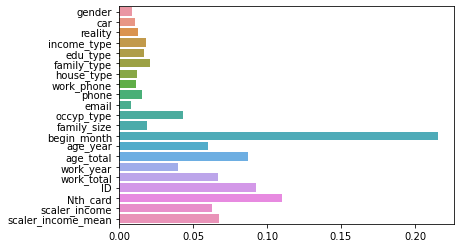

In [25]:
# 특성 중요도 시각화
import seaborn as sns
feature_names = list(train_x.columns)
sns.barplot(clf.feature_importances_, y=feature_names)

In [26]:
#Run KFOLD
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)
        
        predictions=clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(clf)

FOLD 0 : logloss:0.7763840687710613
FOLD 1 : logloss:0.7678638117615557
FOLD 2 : logloss:0.7737026900859489
FOLD 3 : logloss:0.7924716470159112
FOLD 4 : logloss:0.7930514153479364
Mean:0.7806947265964828


In [27]:
my_submission

array([[0.194, 0.75 , 0.056],
       [0.424, 0.196, 0.38 ],
       [0.202, 0.104, 0.694],
       ...,
       [0.168, 0.27 , 0.562],
       [0.25 , 0.216, 0.534],
       [0.296, 0.154, 0.55 ]])

In [28]:
submission.loc[:,1:]=my_submission
#submission.to_csv('1102_scale_1.csv', index = False)

In [29]:
my_submission

array([[0.194, 0.75 , 0.056],
       [0.424, 0.196, 0.38 ],
       [0.202, 0.104, 0.694],
       ...,
       [0.168, 0.27 , 0.562],
       [0.25 , 0.216, 0.534],
       [0.296, 0.154, 0.55 ]])